# Notebook content

1. [__Reading Data__](#1.)


2. [__EDA__](#2.)
    * 2.1 [__Looking closely the features__](#2.1.)
    * 2.2 [__Bivariate Analysis__](#2.2.)
   
    
3. [__Feature Engineering__](#3.)
    * 3.1 [__Fighting outliers__](#3.1.)
    * 3.2 [__Pipelines__](#3.2.)
    * 3.3 [__Some imbalance techniques__](#3.2.)
    
4. [__MODEL__](#4.)
 
5. [__MODEL Evaluation__](#5.)

# 1. Reading Data <a id="1."></a>



In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import QuantileTransformer,FunctionTransformer,RobustScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.pipeline import Pipeline as realPipeline

from xgboost import XGBClassifier 
from catboost import CatBoostClassifier as Model

In [86]:
data=pd.read_csv("/kaggle/input/water-quality-and-potability/water_potability.csv")

data.head(4)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0

In [87]:
data.shape

(3276, 10)

In [88]:
data.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [89]:
describe = data.describe().T
describe.style.background_gradient(cmap = "Oranges")

In [90]:
null_data = data.isnull().sum()
percent_null = (data.isnull().sum() / data.shape[0]) * 100  # Calculate the percentage of null values

null_df = pd.DataFrame({'null_values': null_data, 'percent': percent_null})
null_df.style.background_gradient(cmap="turbo")

* We'll handle it null values when we see features has what kind of distribution is that. 


* We'll use SimpleImputer in the pipeline


# 2. EDA <a id="2."></a>

* Do we have imbalance dataset ? 
* Looking at the distribution of features
* Bivariate Analysis

### 2.1. Looking closely the features <a id="2.1"></a>

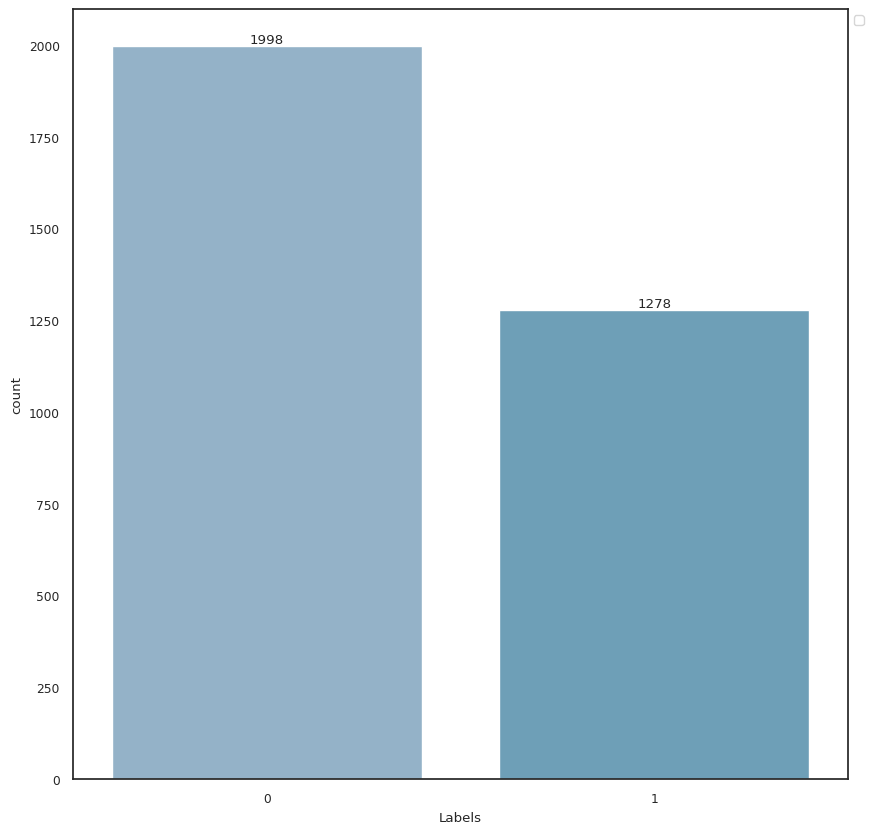

In [91]:
plt.figure(figsize=(10,10))

ax=sns.countplot(data=data,x="Potability")

for label in ax.containers:
    ax.bar_label(label)
    
plt.xlabel("Labels")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



In [92]:
columns  = data.columns
nunique = pd.DataFrame(data[columns].nunique())
nunique.style.background_gradient(cmap="turbo")

* All features is contiounus type

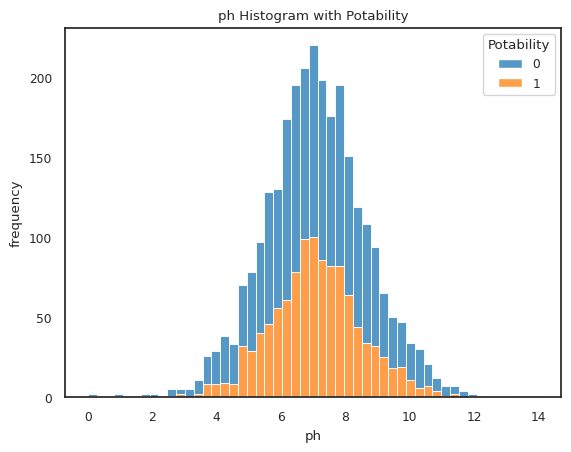

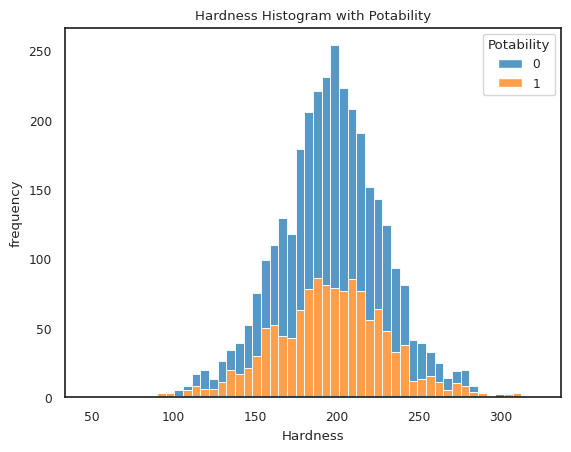

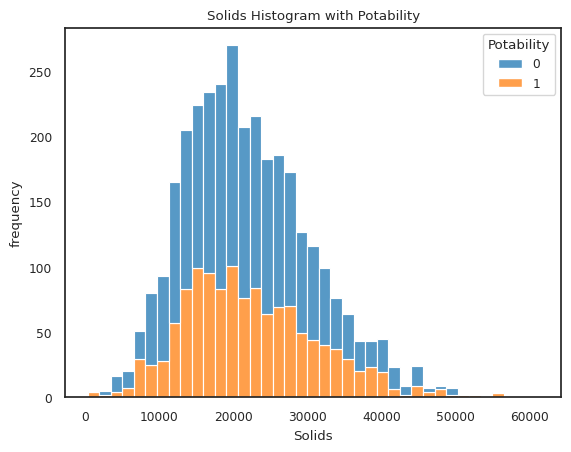

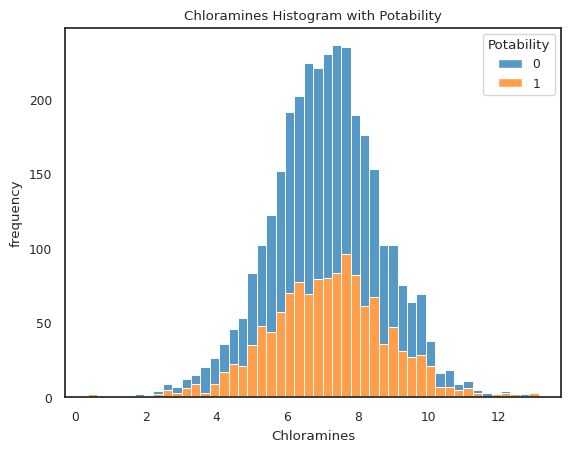

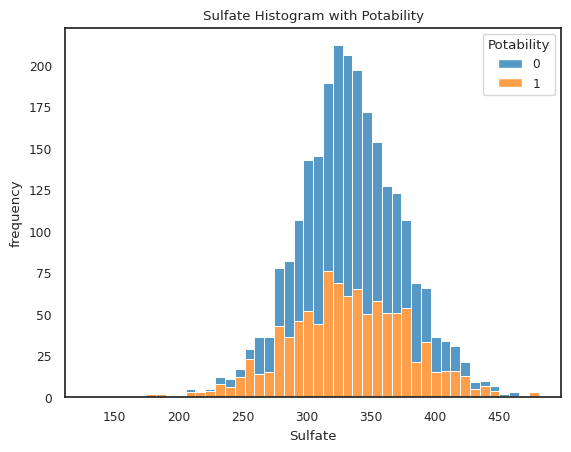

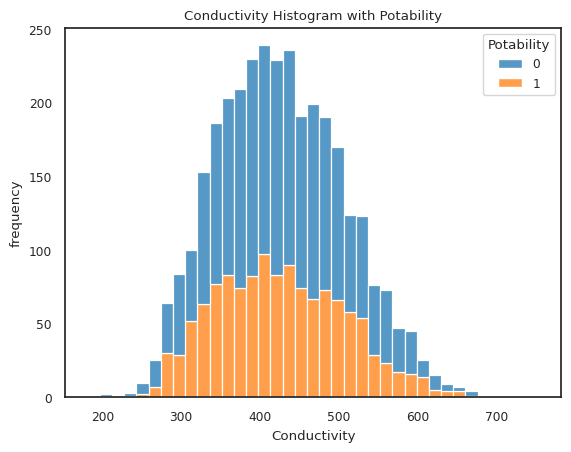

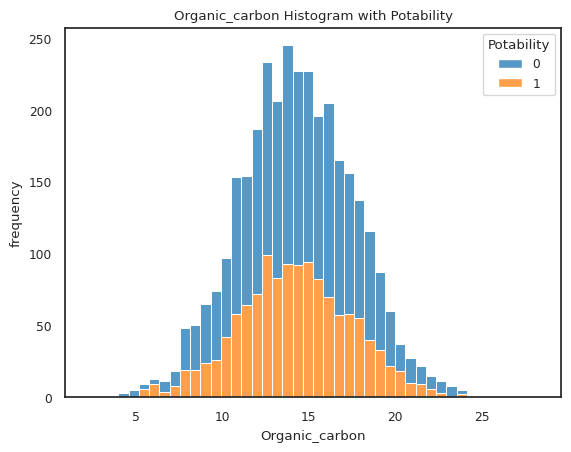

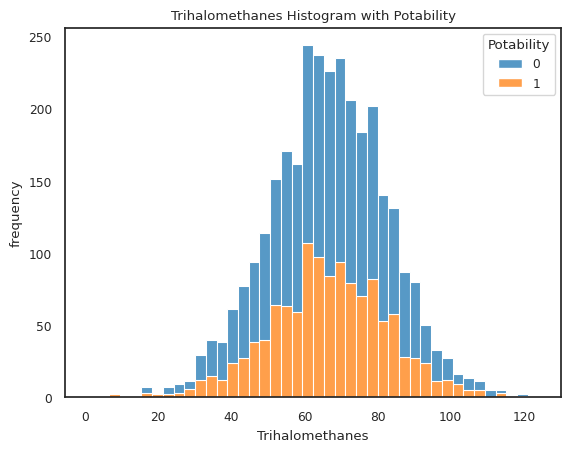

In [93]:


num_rows=["ph","Hardness","Solids","Chloramines","Sulfate","Conductivity","Organic_carbon","Trihalomethanes"]


for num_row in num_rows:
    sns.histplot(data=data,x=num_row,hue='Potability',multiple="stack",palette="tab10")
    plt.title(f"{num_row} Histogram with Potability")
    plt.xlabel(f"{num_row}")
    plt.ylabel("frequency")
    
    
    
    plt.show()

* In general, the features appear normal, but only the Solids feature is right skewed. Therefore, we will fill null values with the "mean" features when using SimpleImputer

* Another important point is the distribution range of the data. Some features have high values while others have lower ranges. This forces us to scale the some features.

### 2.2. Bivariate Analysis <a id="2.2"></a>

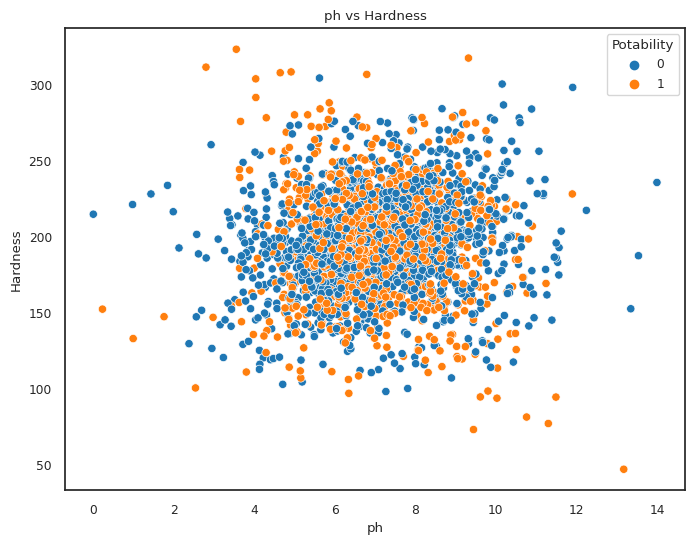

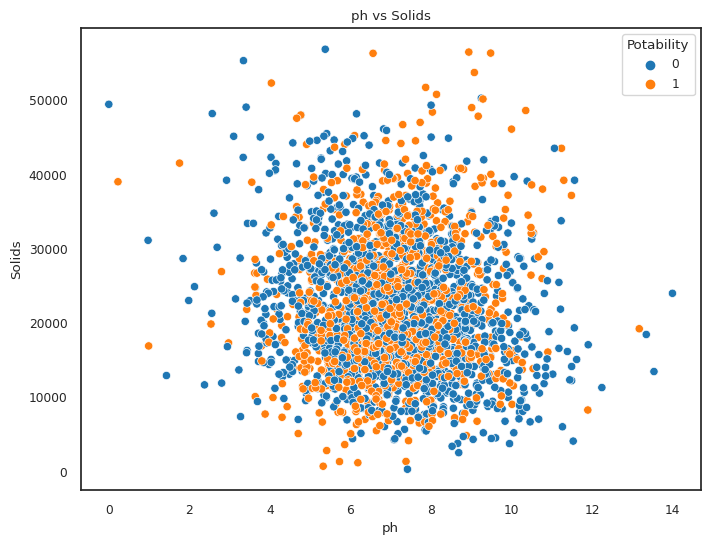

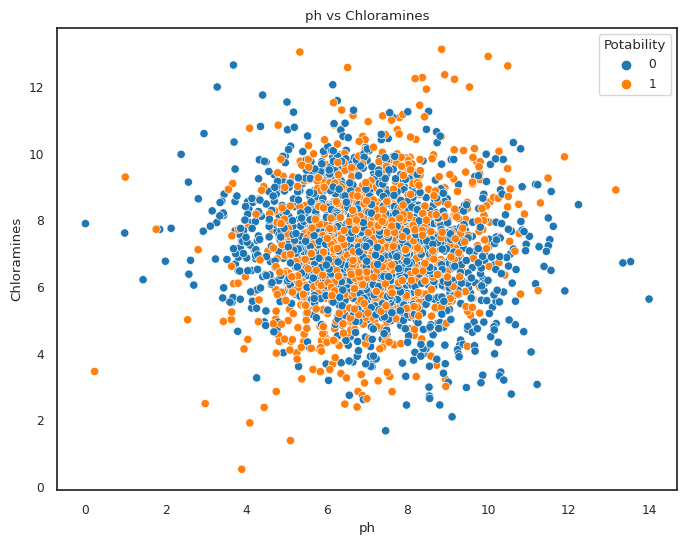

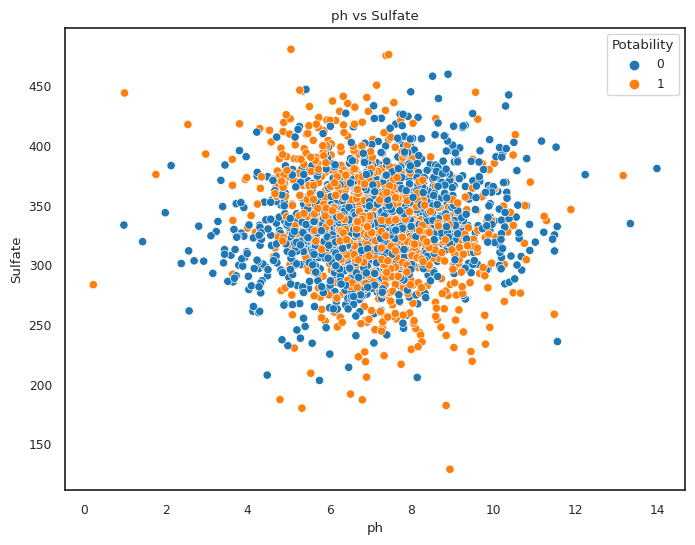

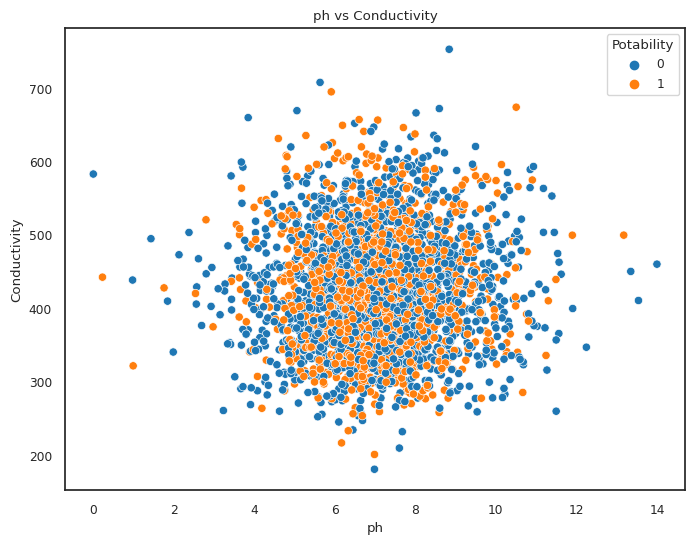

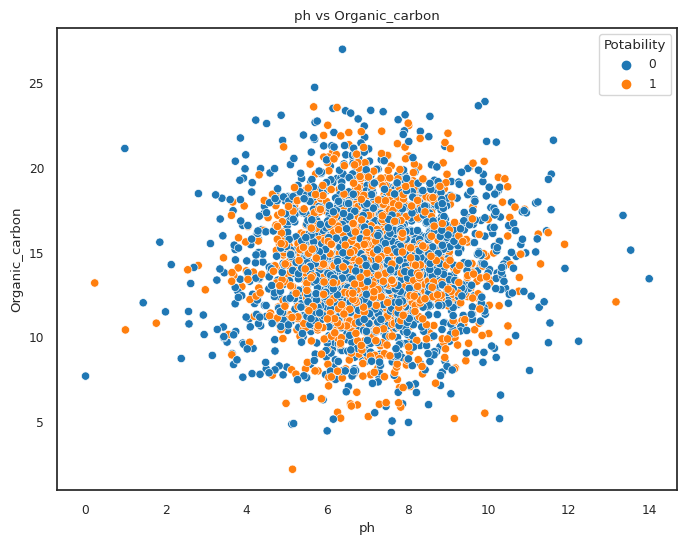

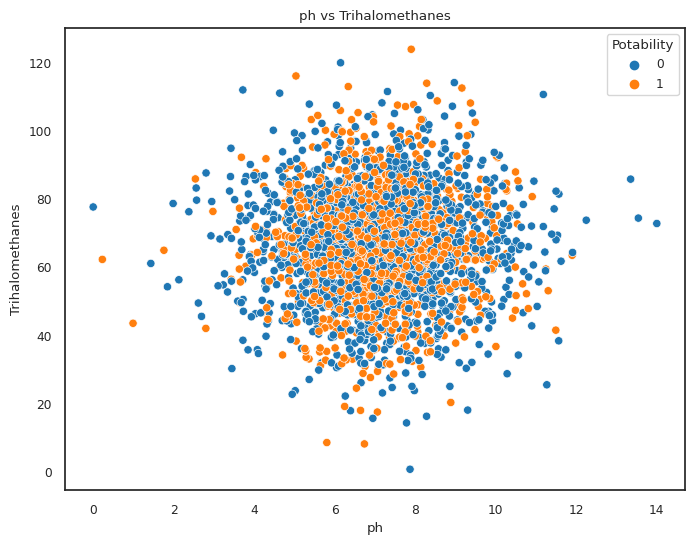

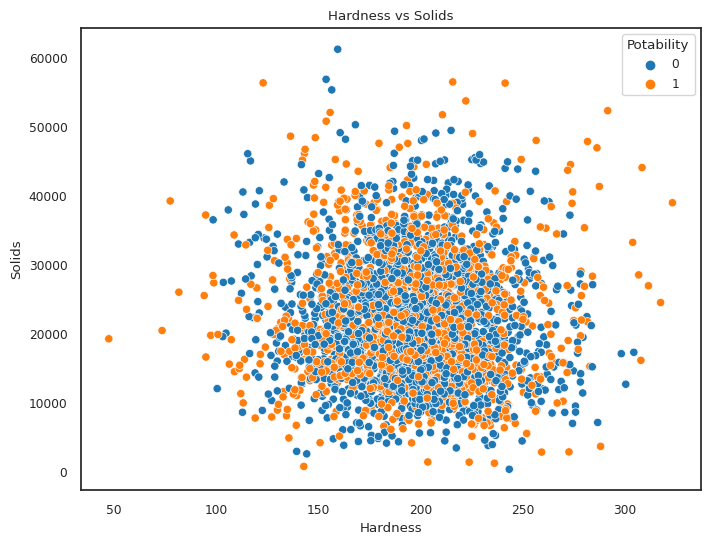

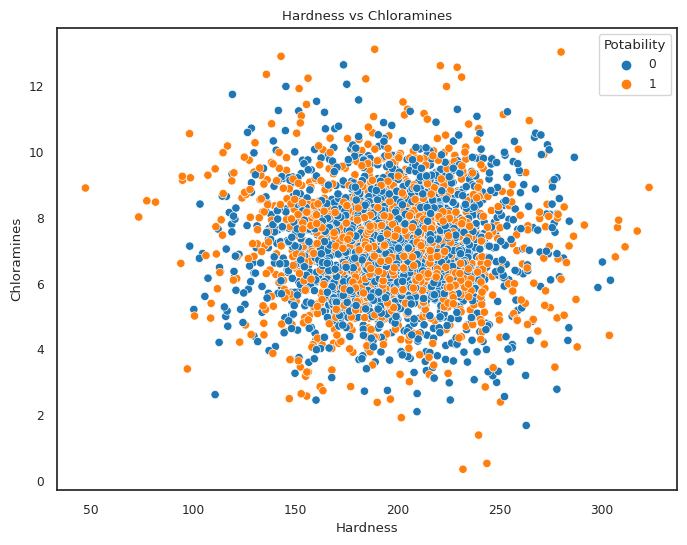

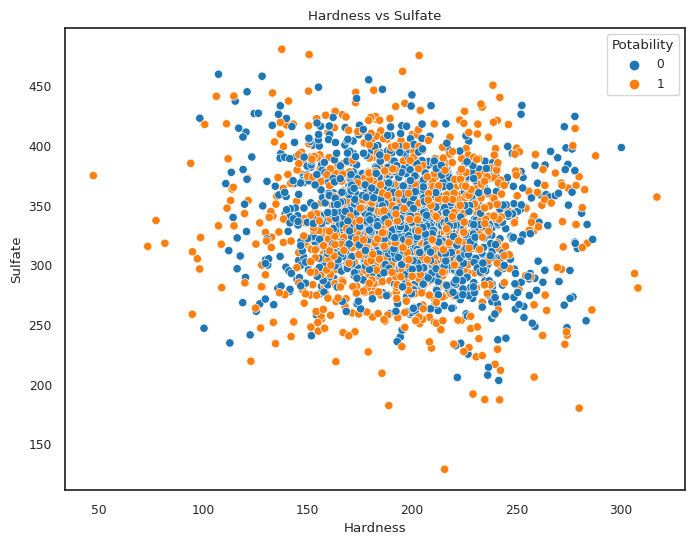

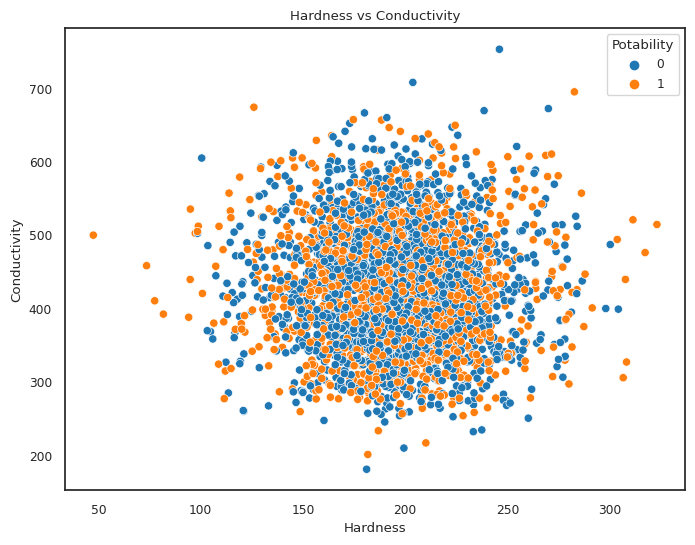

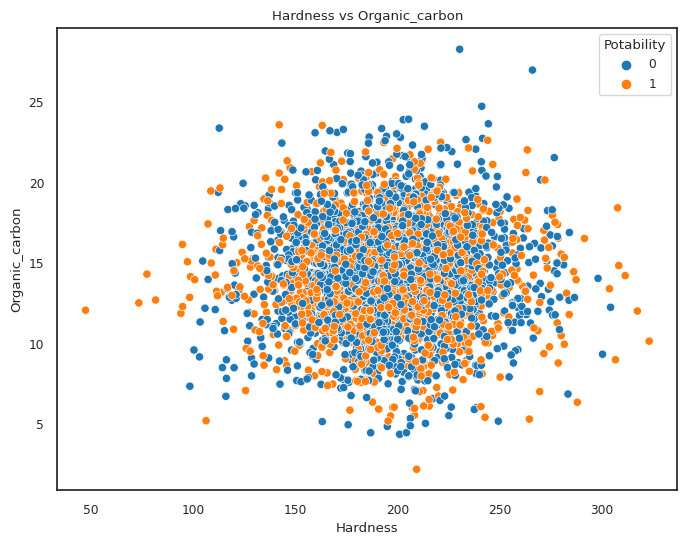

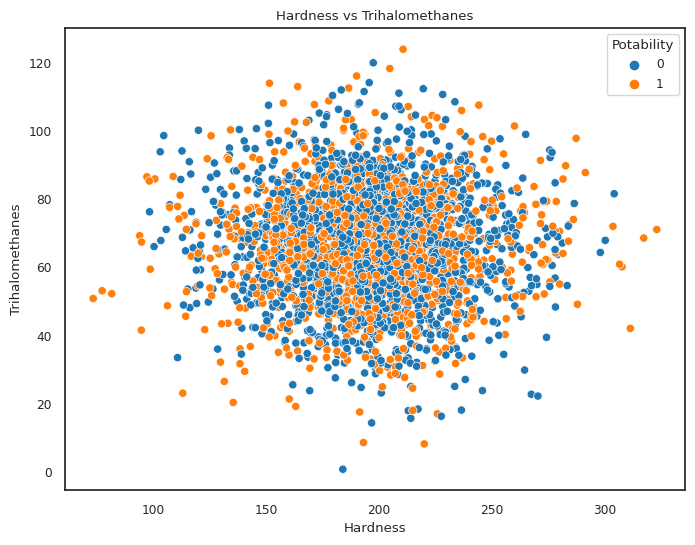

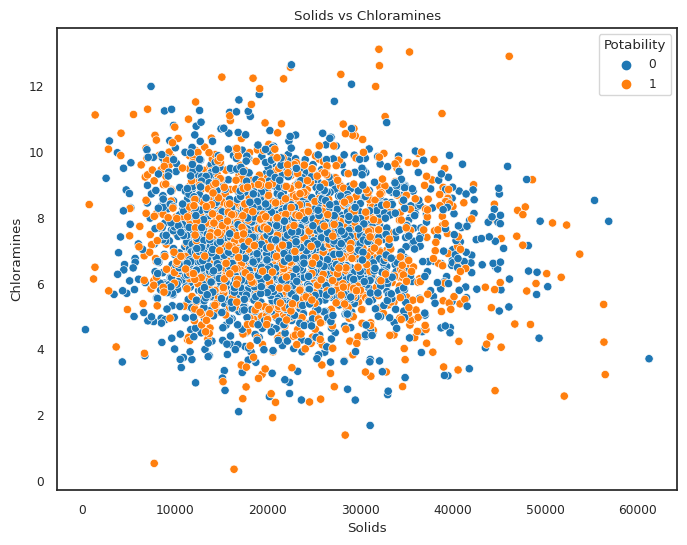

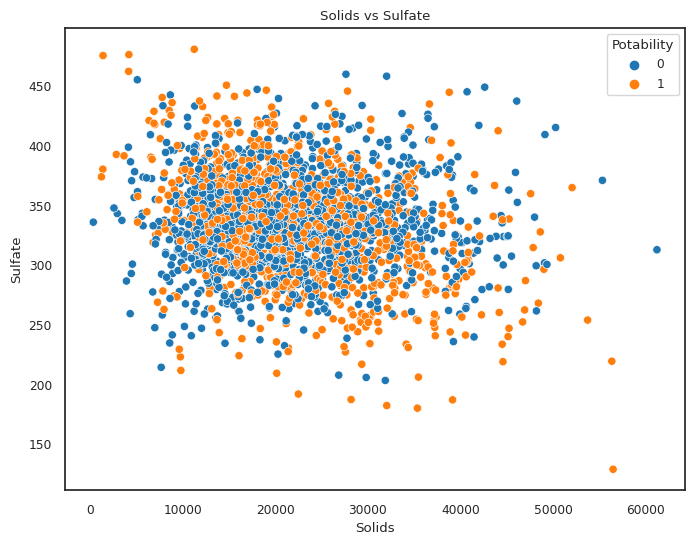

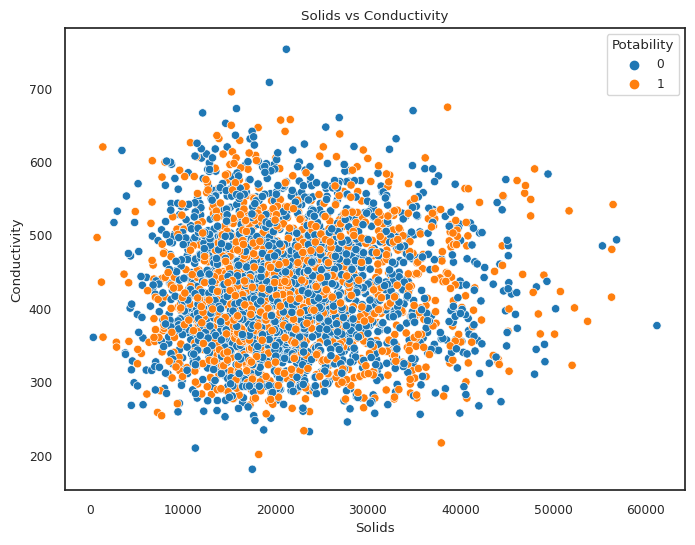

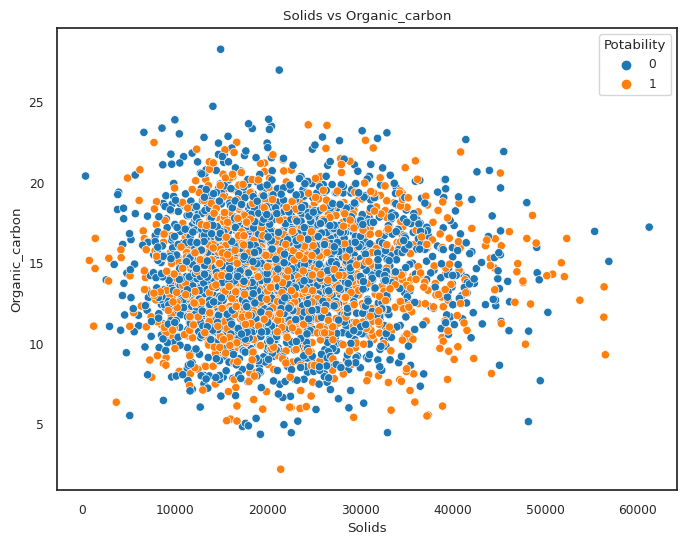

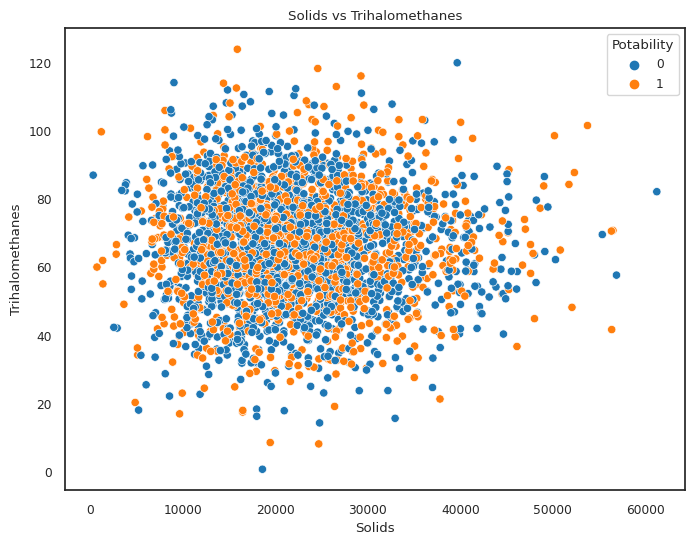

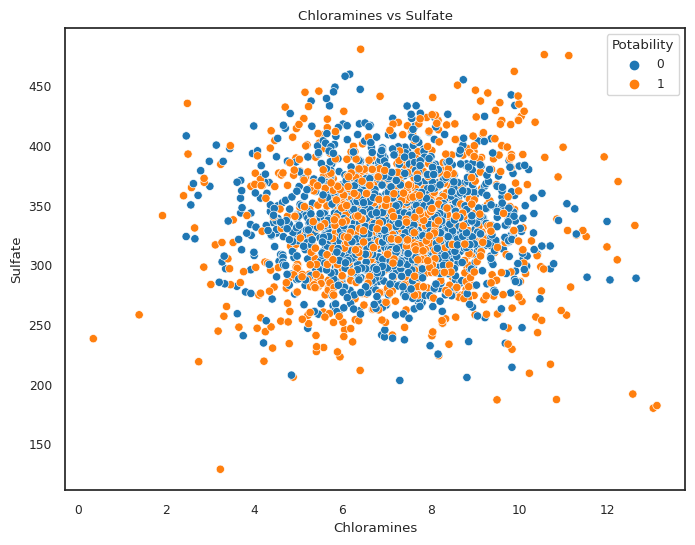

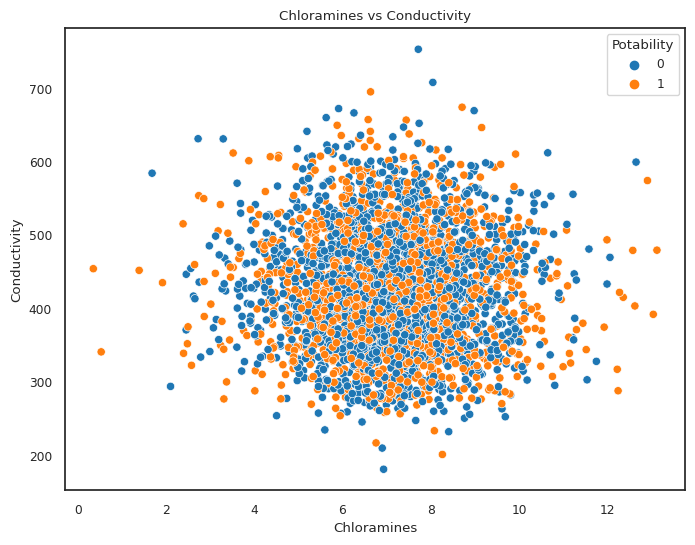

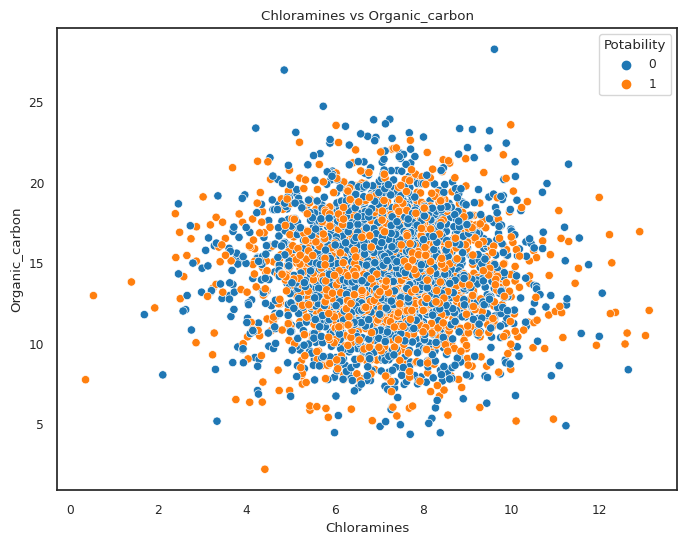

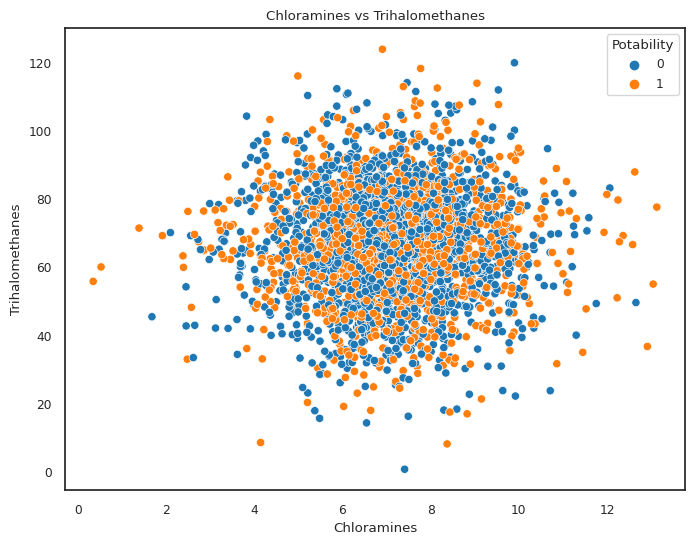

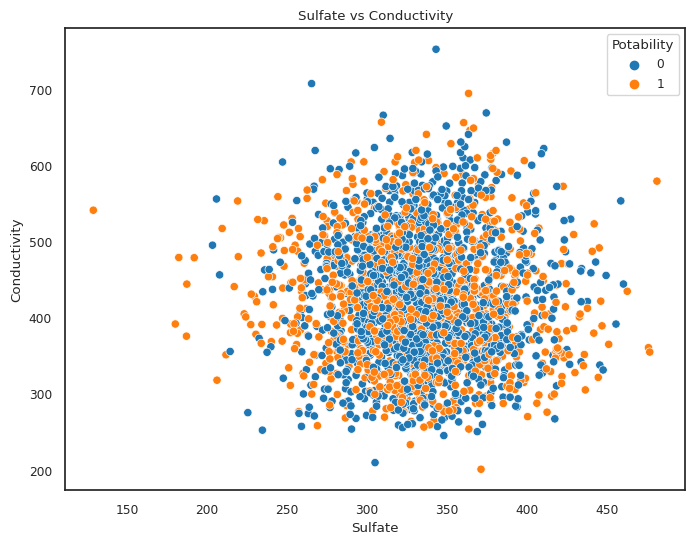

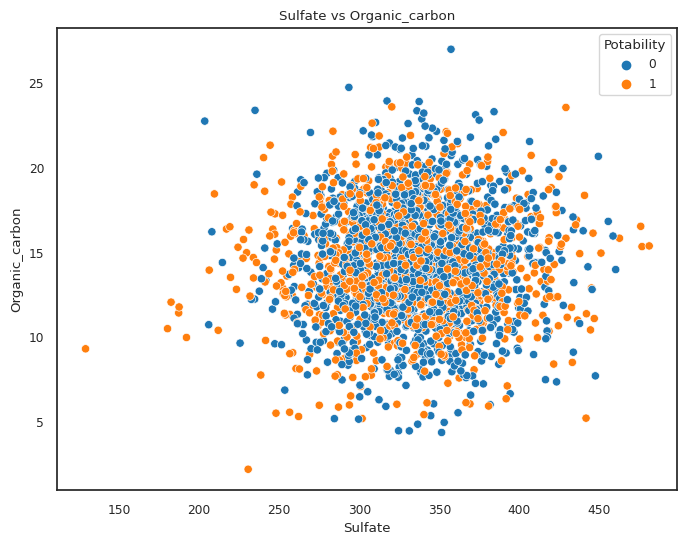

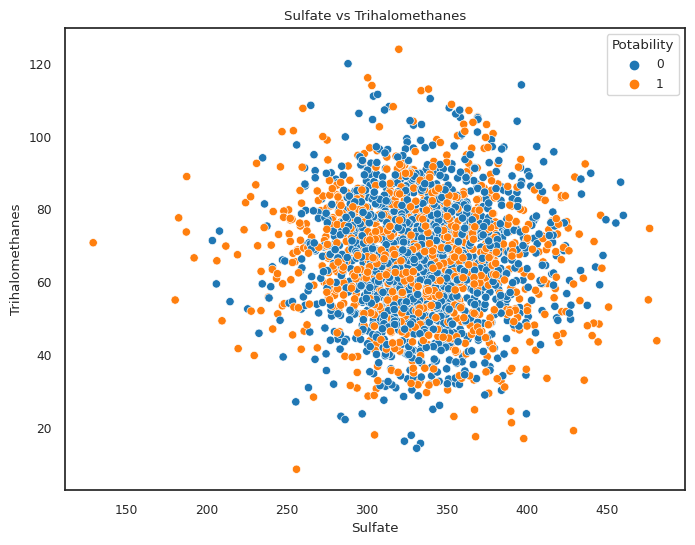

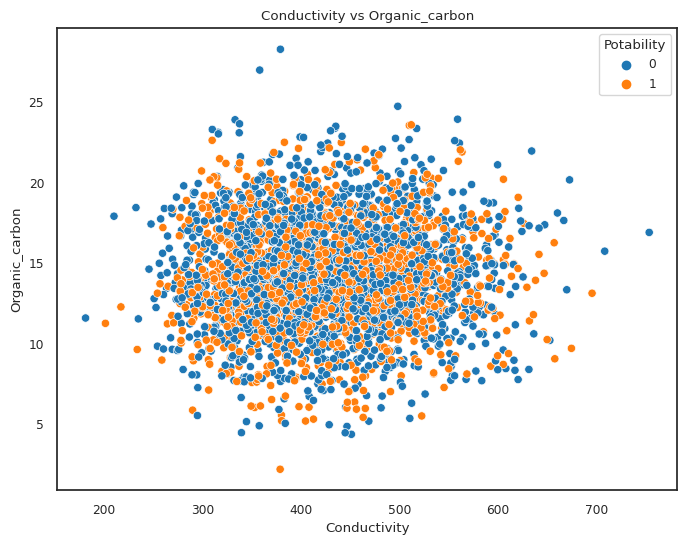

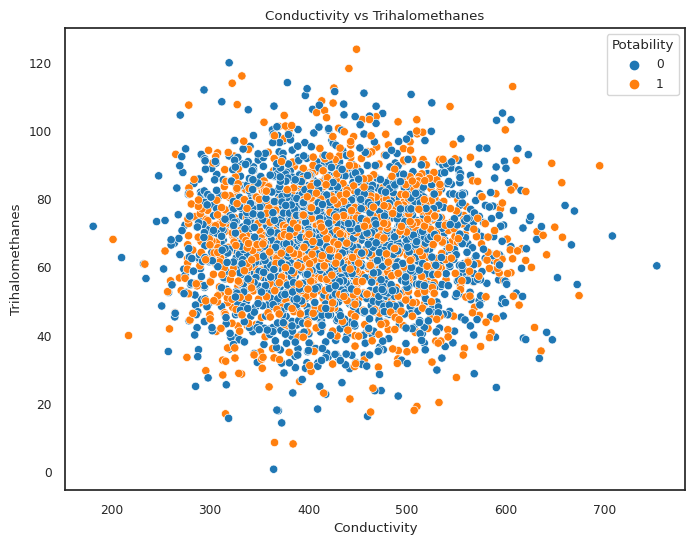

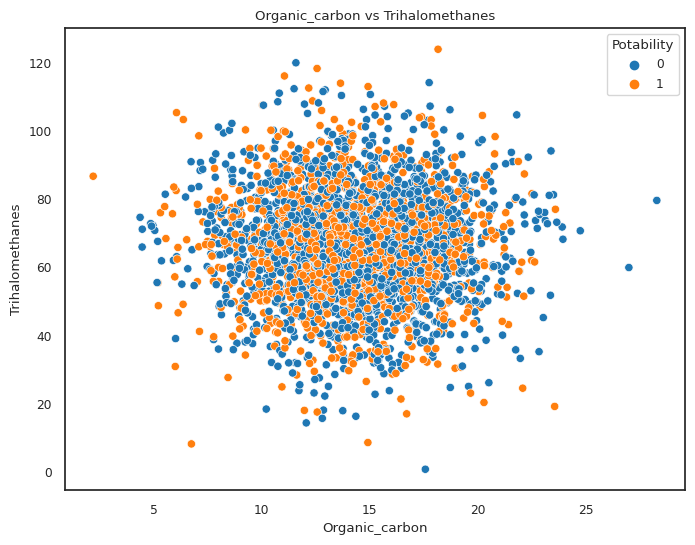

In [94]:
for i in range(len(num_rows)):
    for j in range(i+1, len(num_rows)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data, x=num_rows[i], y=num_rows[j],hue="Potability",palette="tab10")
        plt.title(f"{num_rows[i]} vs {num_rows[j]}")
        plt.show()

* Unfourtanely, there's no higher correlation between features. (positive or negative) 



Reference: 

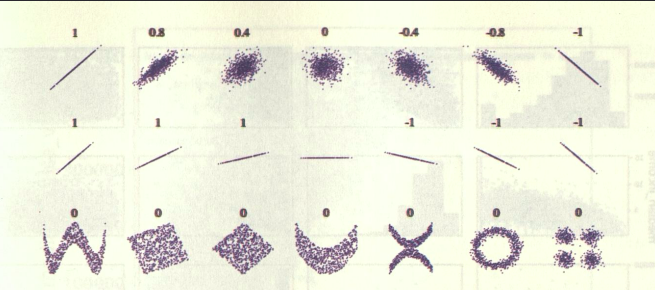

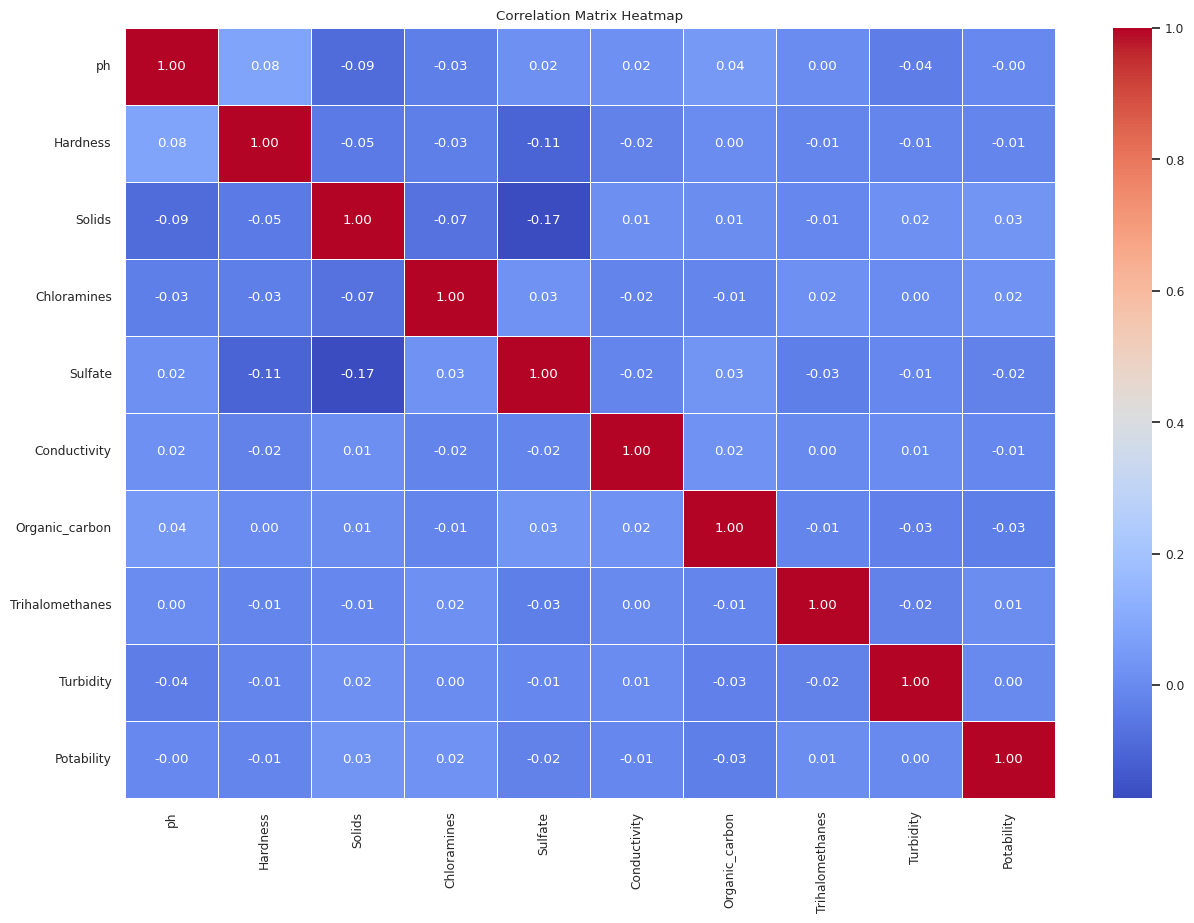

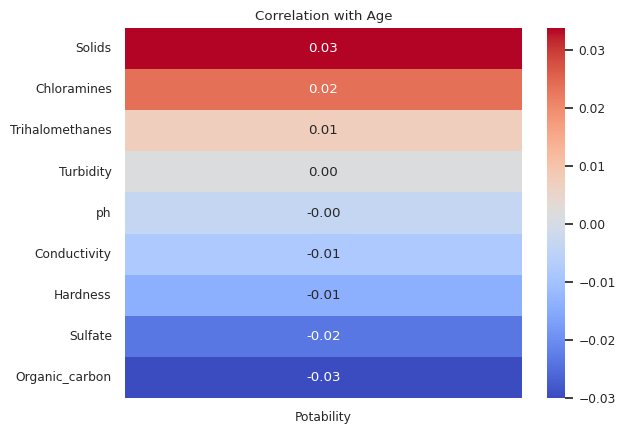

In [95]:
#This is a prove

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['Potability'].drop('Potability')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Age')
plt.show()


* If I'm lying, I'm dying :)

# 3. Feature Engineering <a id="3."></a>


* Fighting Outliers
* Creating Pipeline


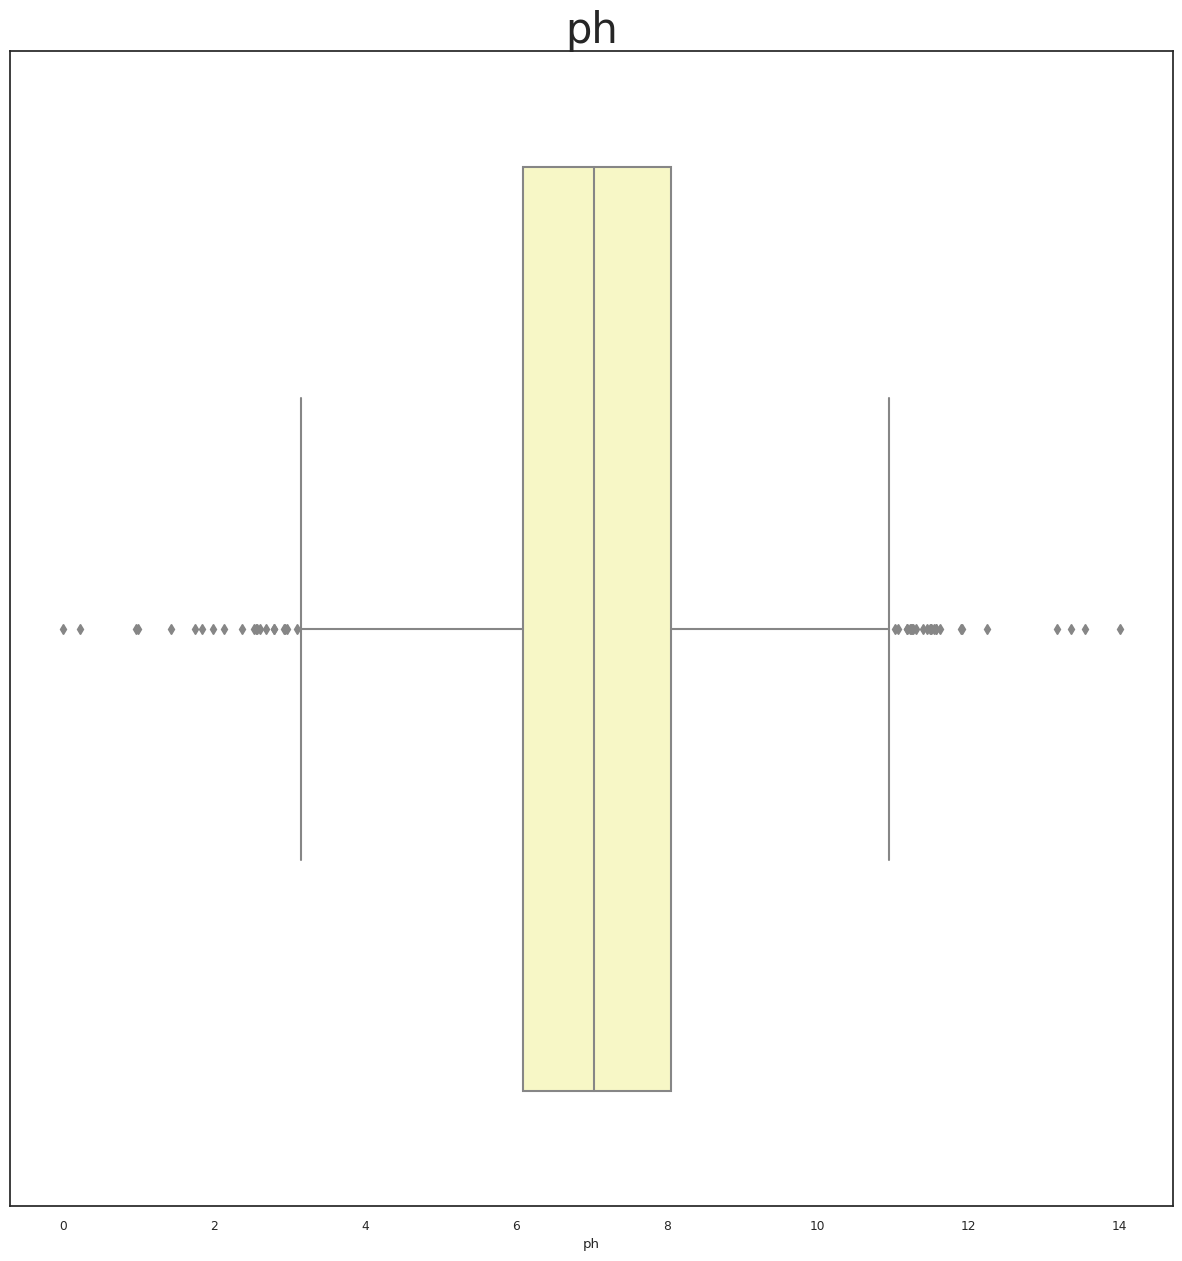

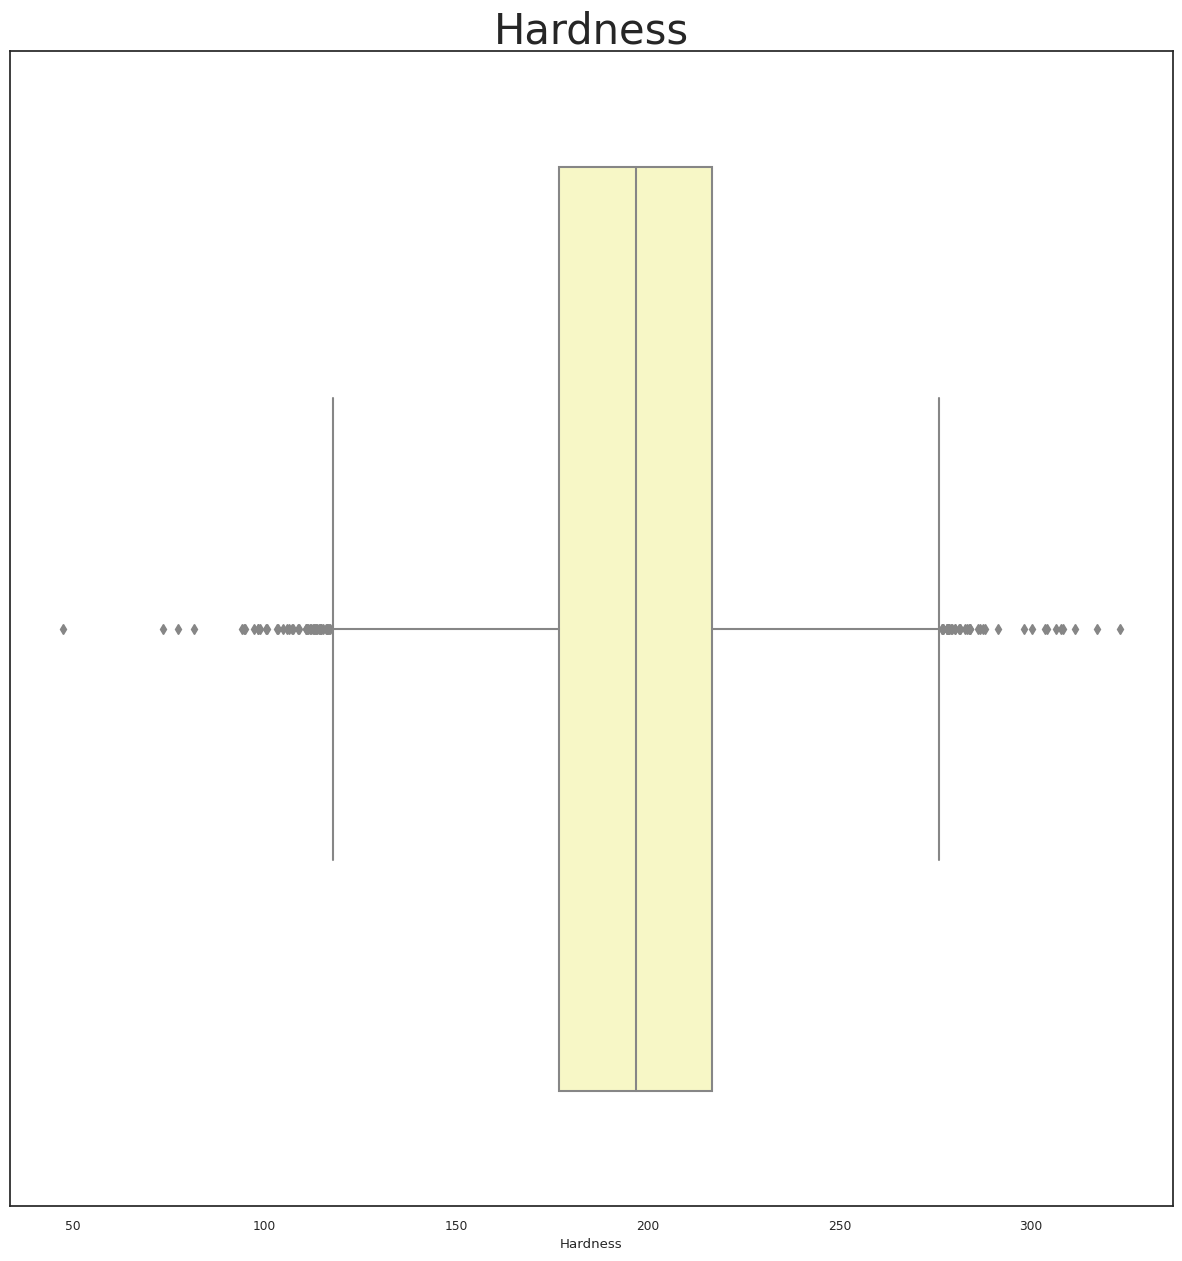

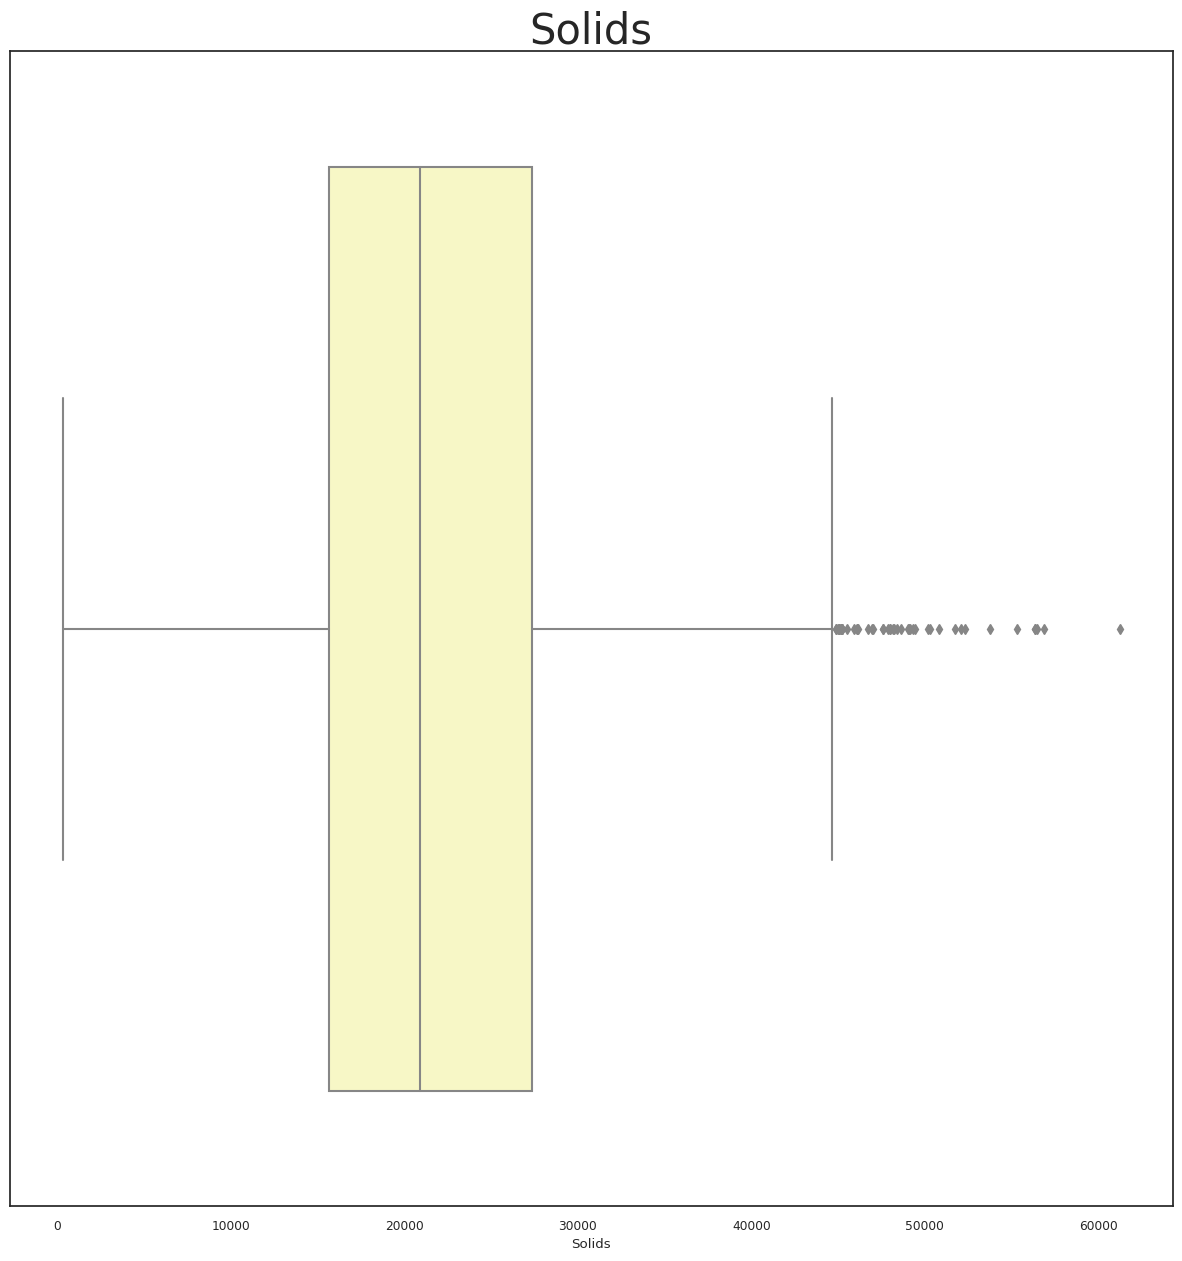

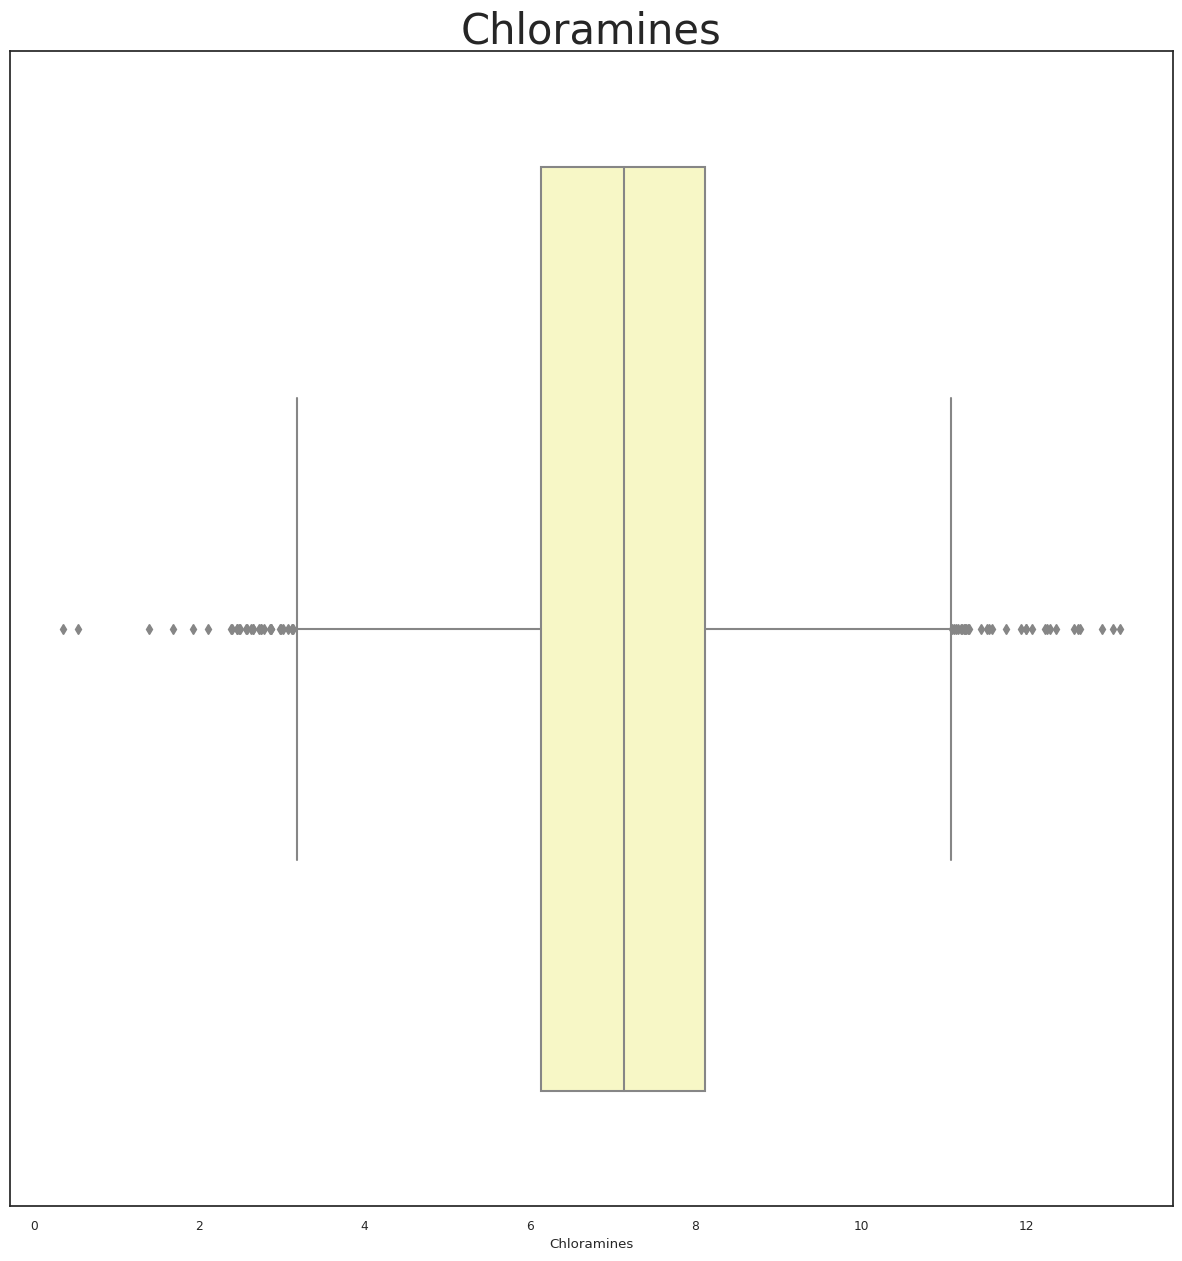

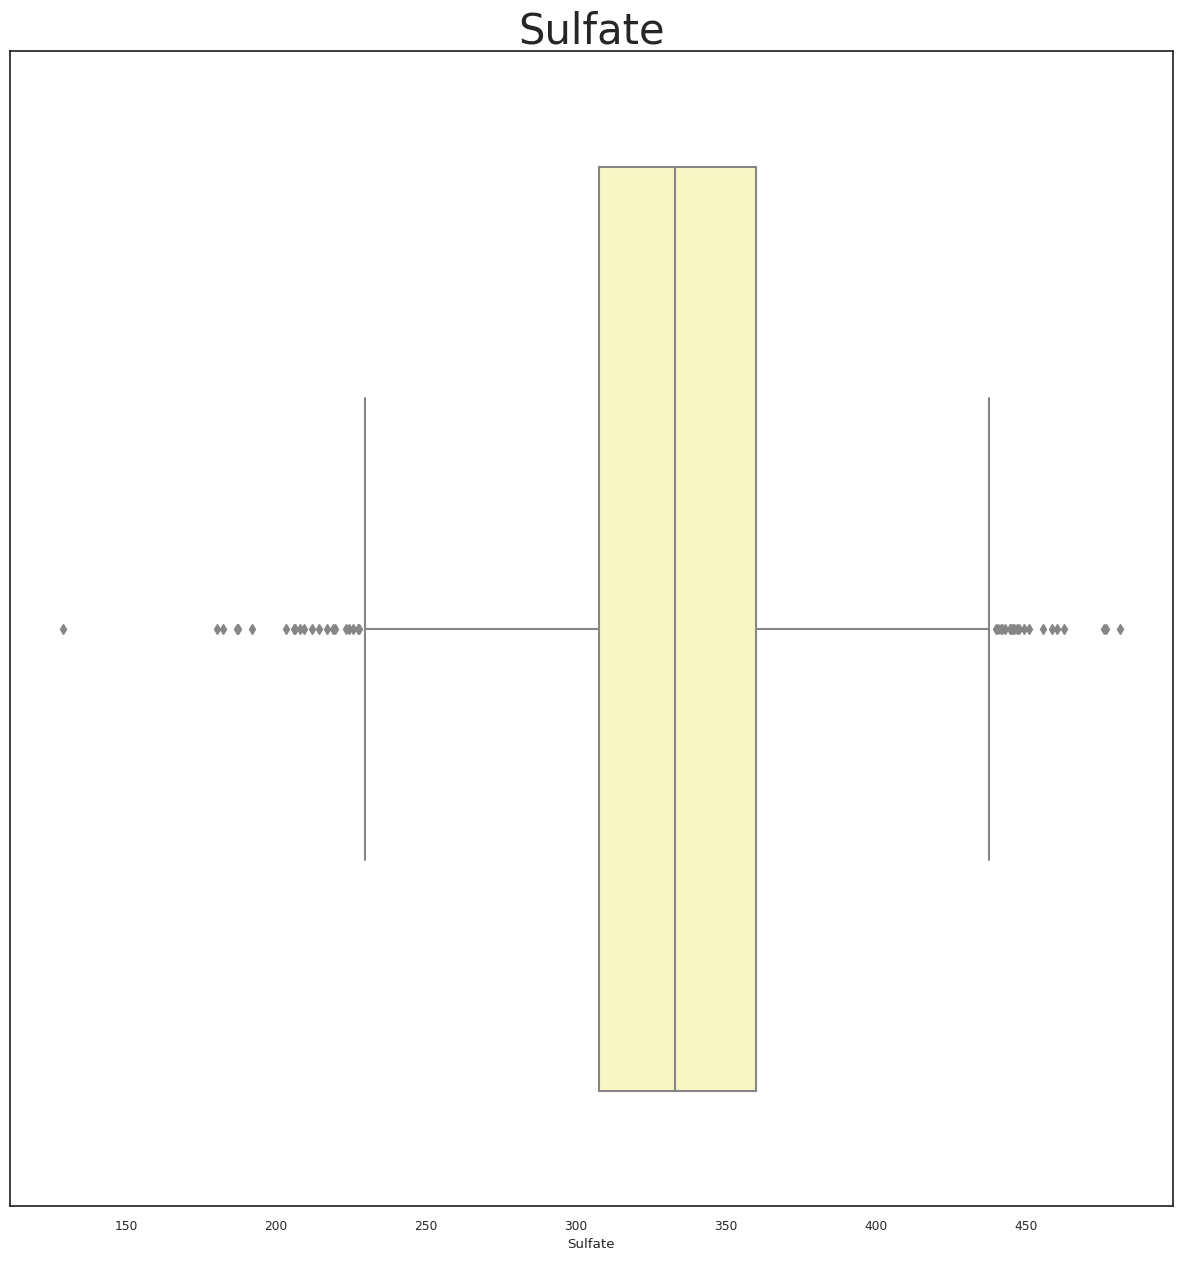

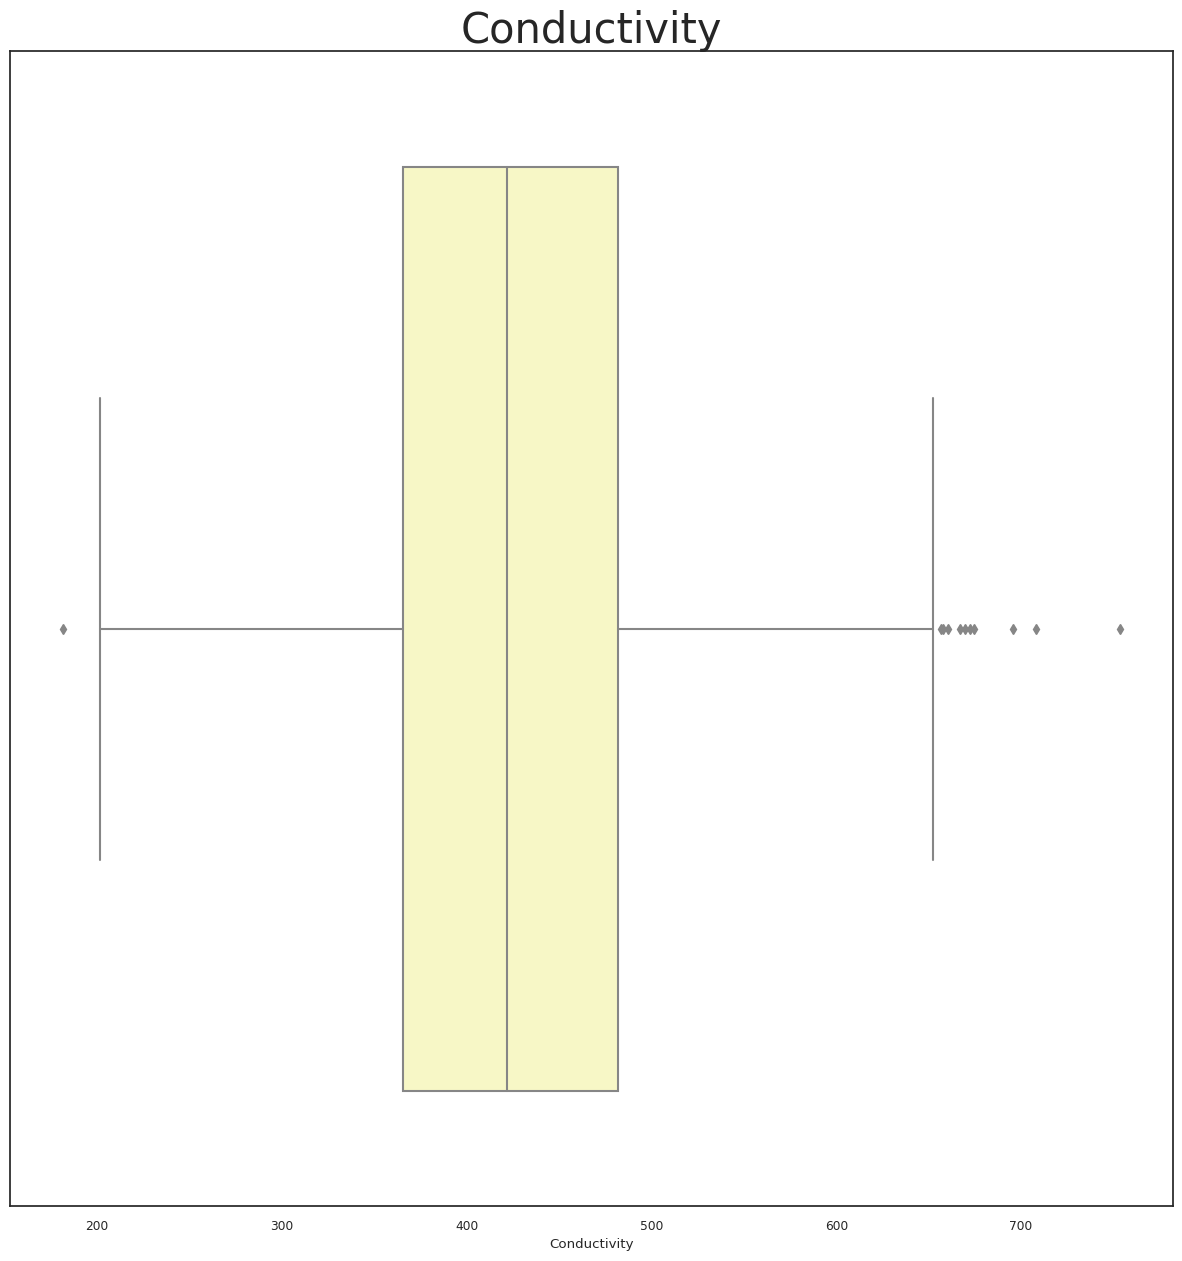

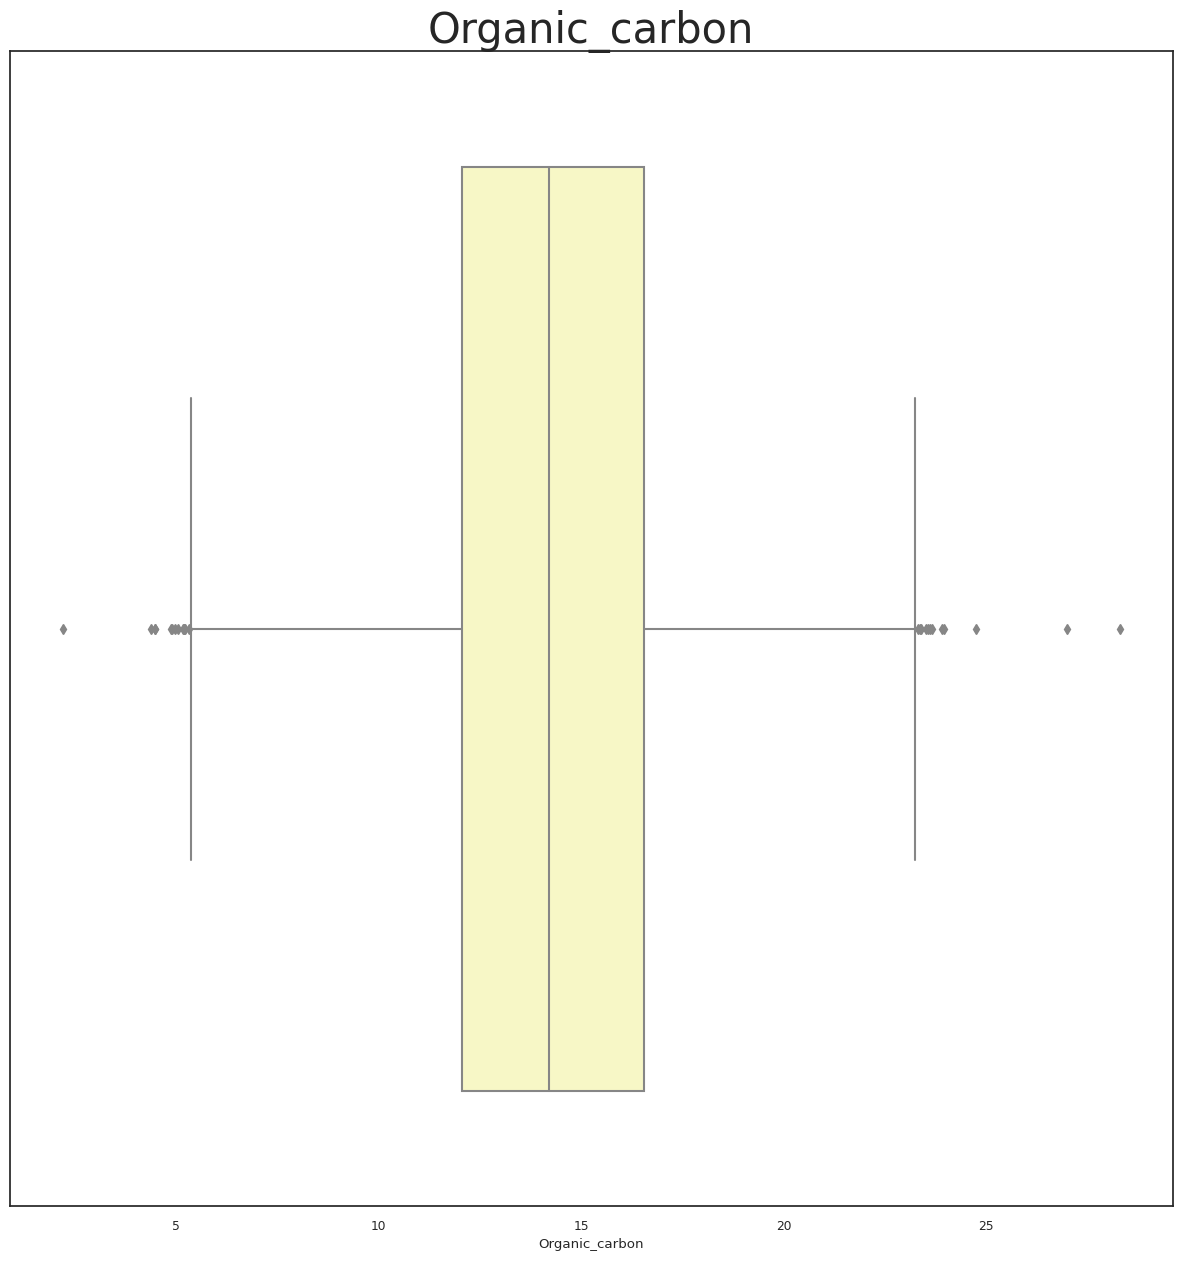

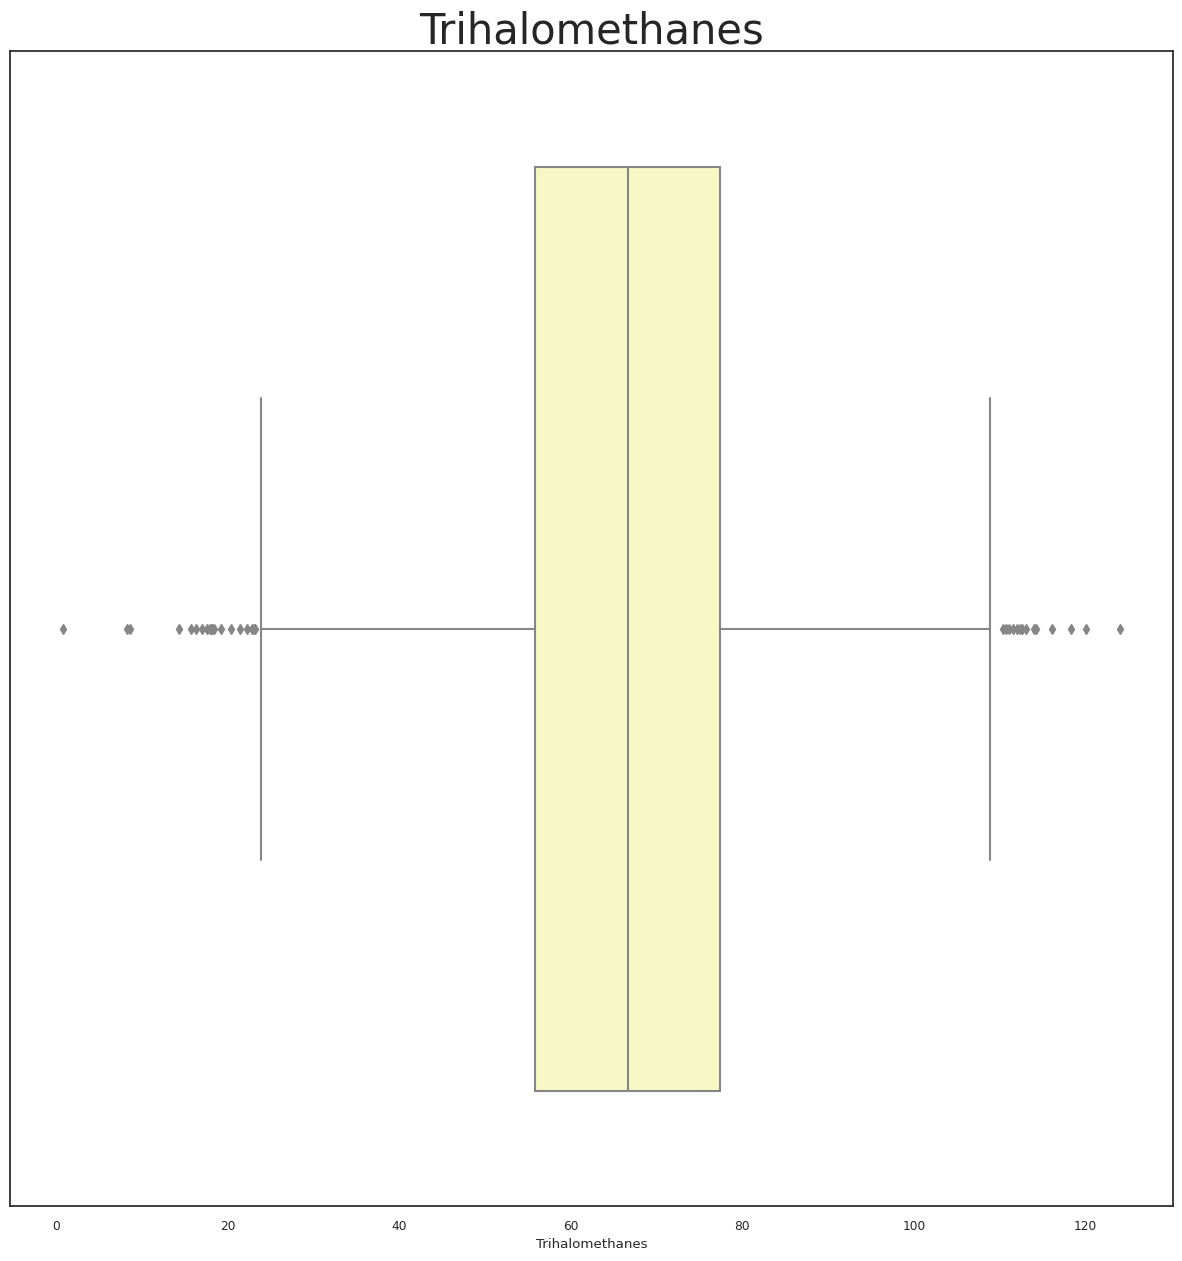

In [96]:
for col in num_rows:
    plt.figure(figsize=(15,15))    
    sns.boxplot(data=data,x=col,palette="Spectral")
    plt.title(f"{col}",fontdict={'size': 30})
    plt.show()

* I see what you see, only outliers transform is apply to Solids. Because another features' scale is not too high. It's from my point of view. You can write Comments what's your thoughts pls.

* Let's do it..

In [97]:
def outlier_analysis_dataframe(dataframe, col):
    outlier_dict = {} 

    # Selected column
    column_data = dataframe[col]

    sorted_data = sorted(column_data)

    # Calculate Q1 and Q3
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    # IQR (Interquartile Range)
    iqr = q3 - q1

    # Lower and Upper outlier sınırlarını hesapla
    alt_sinir = q1 - 1.5 * iqr
    ust_sinir = q3 + 1.5 * iqr

    # Find Outliers
    outliers = [x for x in sorted_data if x < alt_sinir or x > ust_sinir]

    
    df_copy = dataframe.copy()
    df_copy[col] = np.where((df_copy[col] < alt_sinir) | (df_copy[col] > ust_sinir), (q1 + q3) / 2, df_copy[col])

    outlier_dict[col] = outliers

    return df_copy, outlier_dict

In [98]:
column_name = 'Solids'  #Select columns which you want apply IQR 
df_without_outliers, outliers_dict = outlier_analysis_dataframe(data, column_name)


In [99]:
outliers_dict
print(len(outliers_dict))

1


In [100]:
new_data= df_without_outliers

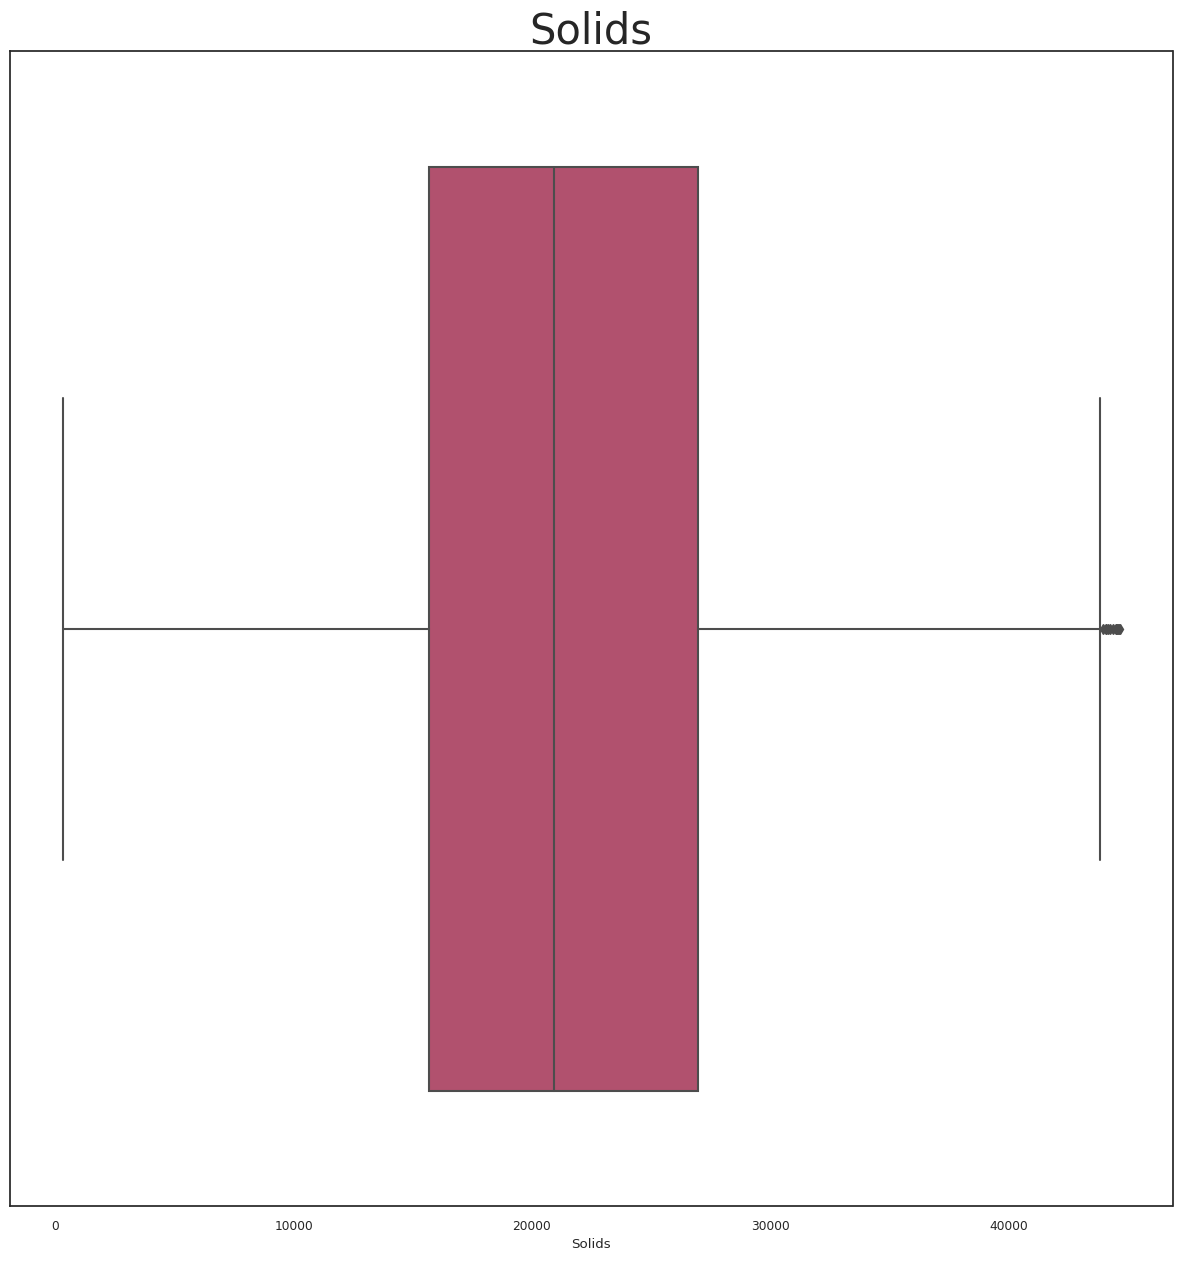

In [101]:
plt.figure(figsize=(15,15))    
sns.boxplot(data=new_data,x="Solids",palette="flare")
plt.title("Solids",fontdict={'size': 30})
plt.show()

* Now is better than before

## Fighting NaN values

* There is the features which is has nan values: 
    
    * ph
    * Sulfate
    * Trihalomethanes
    
   
* ph and Trihalomethanes has normal distrubition but Sulfate has left skew, I'm gonna reference this image and I'll choose "mean" strategy because we needed normal distrubition


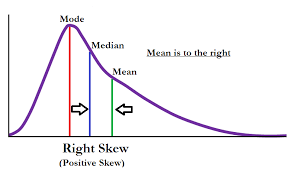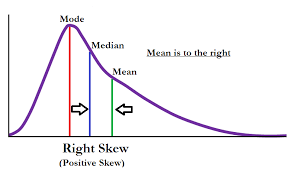

## Creating Pipeline Object

* I'll apply step by step these things;
    * SimpleImputer
    * [QuantileTransformer](https://scikit-learn.org/stable/modules/generate/sklearn.preprocessing.QuantileTransformer.html) or Robust Scaler 

In [102]:
# Define your numeric_transform pipeline
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', PowerTransformer())
])


# Define your preprocessing_pipeline with distinct step names
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('numeric', numeric_transform, num_rows),

])
param={
    
    'l2_leaf_reg': 0.0028772916926549765, 'max_bin': 390, 'learning_rate': 0.011398945601759285, 'n_estimators': 379, 'max_depth': 9, 'random_state': 2021
}

# Define your model_pipeline (replace "Model()" with your actual model)
model_pipeline = realPipeline(steps=[
    ('preprocess', preprocessing_pipeline),
    ('smote', SMOTE()),
    ("model", Model(**param))  
])


* I've been tried some smote techniques:
* With XGBoost
    * ADASYN --->  Mean F1-Score : 59.43%  Standart standard deviation: 0.39%
    * BorderlineSMOTE --> Mean F1-Score : 61.44% Standart standard deviation: 1.59%
    * SMOTE --> Mean F1-Score : 61.44% Standart standard deviation: 1.59%
    
 * But Catboost's result's
     * learning rate 0.3 ,"n_estimators : 300 , test size (0.07)--> Mean F1-Score : 61.11% Standart standard deviation: 1.86%
     * learning rate 0.1, "n_estimators : 500 , changing test size (0.15) --> Mean F1-Score : 62.52% Standart standard deviation: 0.84%
     * SMOTE --> k_neighbors: 3,5,7  -->  Mean F1-Score : 62.25% Standart standard deviation: 2.07%,Mean F1-Score : 61.20% Standart standard deviation: 1.33%
 

In [103]:
X= data.drop('Potability',axis=1)
y= data["Potability"]

## Test-Train Split

In [104]:
np.random.seed(23)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.09, random_state=24)

## Optuna

In [105]:
#Optuna
#import optuna
#from optuna.samplers import TPESampler
#from sklearn.model_selection import KFold
#from catboost import CatBoostClassifier
#from sklearn.metrics import accuracy_score


#def objective(trial):

#    param = {
#        'loss_function': 'Logloss',
#        #'task_type': 'GPU',
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
#        'n_estimators': trial.suggest_int('n_estimators', 350, 400),
#        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11]),
#      'random_state': trial.suggest_categorical('random_state', [2020, 2021]),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#    }

#    kf = KFold(n_splits=5)
#    acc = []
#    for train_index, val_index in kf.split(X, y):
        
        # Split the data into training and validation sets
#        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#       y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create a CatBoostClassifier model
#        model = CatBoostClassifier(**param)

        # Fit the model to the training data
#        model.fit(X_train, y_train,verbose=0)

        # Evaluate the model on the validation data
#        score = accuracy_score(y_val, model.predict(X_val))
#        acc.append(score)

#    return np.mean(acc)


#sampler = TPESampler(seed=1)
#study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=10, show_progress_bar=True)

## Cross-validation

In [106]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=skf,
                            scoring="f1_macro")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {score * 100:.2f}%")

print("---" * 8)
print(f"Mean F1-Score : {cv_scores.mean() * 100:.2f}%")
print(f"Standart standard deviation: {cv_scores.std() * 100:.2f}%")


0:	learn: 0.6900419	total: 31.2ms	remaining: 11.8s
1:	learn: 0.6870198	total: 51ms	remaining: 9.61s
2:	learn: 0.6838352	total: 70.5ms	remaining: 8.84s
3:	learn: 0.6809349	total: 90.2ms	remaining: 8.45s
4:	learn: 0.6774291	total: 110ms	remaining: 8.21s
5:	learn: 0.6737332	total: 129ms	remaining: 8.02s
6:	learn: 0.6698989	total: 148ms	remaining: 7.89s
7:	learn: 0.6661930	total: 169ms	remaining: 7.82s
8:	learn: 0.6622454	total: 189ms	remaining: 7.78s
9:	learn: 0.6585691	total: 209ms	remaining: 7.7s
10:	learn: 0.6553502	total: 228ms	remaining: 7.62s
11:	learn: 0.6526178	total: 249ms	remaining: 7.62s
12:	learn: 0.6506061	total: 269ms	remaining: 7.56s
13:	learn: 0.6470775	total: 288ms	remaining: 7.5s
14:	learn: 0.6428184	total: 307ms	remaining: 7.46s
15:	learn: 0.6404139	total: 327ms	remaining: 7.42s
16:	learn: 0.6377233	total: 347ms	remaining: 7.38s
17:	learn: 0.6346903	total: 366ms	remaining: 7.33s
18:	learn: 0.6309310	total: 386ms	remaining: 7.32s
19:	learn: 0.6275145	total: 407ms	remaini

In [107]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

0:	learn: 0.6903700	total: 31.7ms	remaining: 12s
1:	learn: 0.6871061	total: 51.9ms	remaining: 9.78s
2:	learn: 0.6846646	total: 73.4ms	remaining: 9.19s
3:	learn: 0.6821373	total: 94.3ms	remaining: 8.84s
4:	learn: 0.6780957	total: 116ms	remaining: 8.65s
5:	learn: 0.6757803	total: 136ms	remaining: 8.45s
6:	learn: 0.6720828	total: 157ms	remaining: 8.36s
7:	learn: 0.6692078	total: 180ms	remaining: 8.33s
8:	learn: 0.6662026	total: 201ms	remaining: 8.24s
9:	learn: 0.6635703	total: 222ms	remaining: 8.18s
10:	learn: 0.6599158	total: 245ms	remaining: 8.21s
11:	learn: 0.6563922	total: 267ms	remaining: 8.16s
12:	learn: 0.6541265	total: 286ms	remaining: 8.05s
13:	learn: 0.6509091	total: 305ms	remaining: 7.96s
14:	learn: 0.6482188	total: 325ms	remaining: 7.89s
15:	learn: 0.6458542	total: 345ms	remaining: 7.82s
16:	learn: 0.6437133	total: 365ms	remaining: 7.78s
17:	learn: 0.6405185	total: 385ms	remaining: 7.71s
18:	learn: 0.6379695	total: 404ms	remaining: 7.66s
19:	learn: 0.6348553	total: 424ms	remai

In [108]:
def matrix_confusion(y_test,y_pred):
    from sklearn.metrics import confusion_matrix

    cf_matrix = confusion_matrix(y_test,y_pred)
    fig, ax = plt.subplots(figsize=(15,10)) 
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
    plt.show()

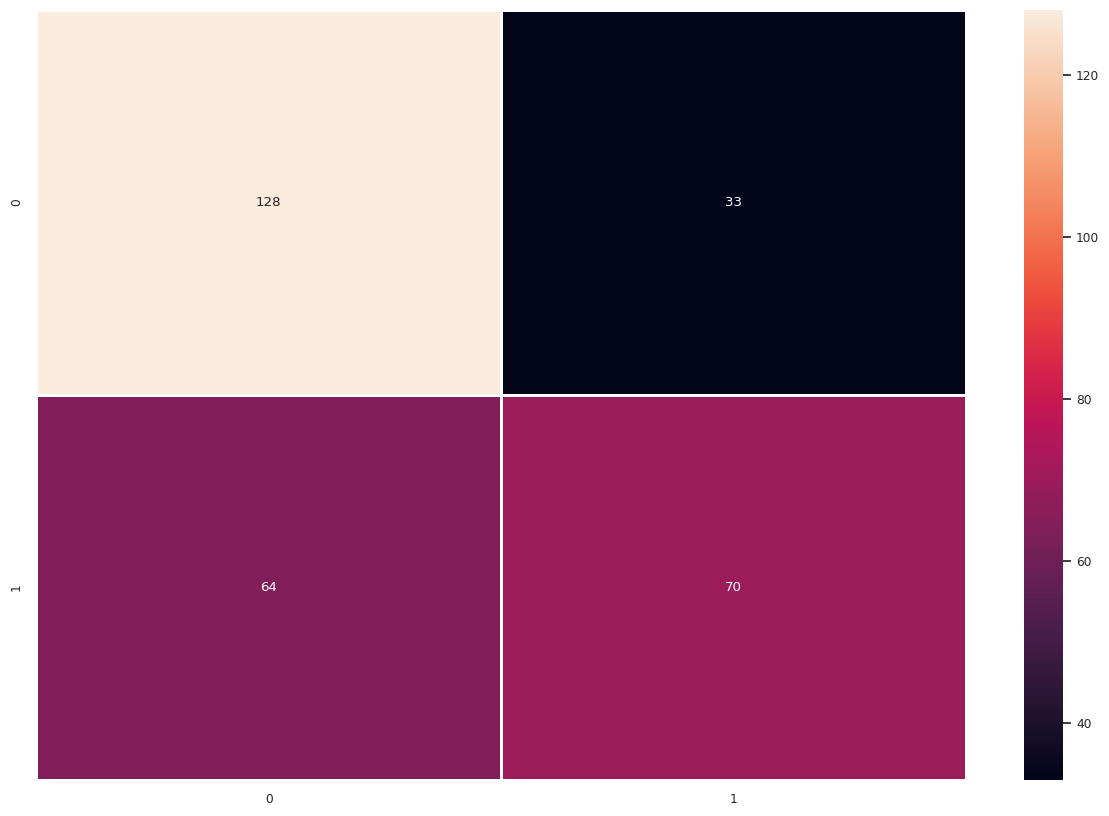

In [109]:
matrix_confusion(y_test, y_pred)

In [110]:
def vis_report_classification(y_hat_xgboost,y_test):
    from sklearn.metrics import classification_report

    df = pd.DataFrame(classification_report(y_hat_xgboost, 
                                        y_test, digits=2,
                                        output_dict=True)).T

    df['support'] = df.support.apply(int)

    
    

    return df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

In [111]:
vis_report_classification(y_pred,y_test)

* Reference: 

* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html#imblearn.over_sampling.KMeansSMOTE

* https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1

* https://github.com/EmKa-Academy/ML-DS-Ogretici-Notebooklar/tree/main

* https://github.com/Yusuf-Cizlasmak/Fundamentals-of-Machine-Learning
